# Create Class to be Used for general Purpsose

In [1]:
import quantecon as qe
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
%matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
class final_Econ602:
    """
    A simple model with uncertainty solved by discrete state space technique.

    Parameters
    ----------
    β : float
        Time discounting parameter
    δ : float
        depreciation rate
    nk : int
        Number of points in k grid
    nz : int
        possibilities of z (markov chain), transition matrix = nz*nz
    tol : float
        Error tolerance in iteration
    maxit : int
        Maximum number of iterations
    μ : float
        preference parameter
    θ : float
        produtivity parameter
    ϕ : float
        parameter for adjustment cost
    ρ : float
        Persistence parameter in AR(1) process
    η : float
        The value of the standard deviation of the ε in AR(1) process
    """

    def __init__(self,
                β=.99,         # time discount rate
                δ=0.025,        # depreciation rate
                θ = 0.36,        # productivity parameter
                μ = 0.34,
                ϕ = 0.025,      # adjustment cost
                ρ = 0.9,       # persistence parameter
                η = 0.01,      # standard deviation
                nk=100,          # number of points in k grid
                nz=7,          #markov chain
                tol=1e-6,       # error tolerance in iteration
                maxit=10000):

        # Save parameters
        self.β, self.μ, self.δ, self.θ = β, μ, δ, θ
        self.ϕ, self.ρ, self.η = ϕ, ρ, η
        self.nz = nz
        self.nk = nk 
        self.tol = tol
        self.maxit = maxit
    
        # Create Markov Chain with transition matrix
        self.markov = qe.markov.tauchen(nz, ρ, η, 0, 3)
        self.probability = self.markov.P
        self.z = self.markov.state_values
        
        ##############################################################################################
        ########################### Create grids and discretize state space ##########################
        ##############################################################################################
        
        # Using the steady state labor for model with certainity since it would not matter if we expand
        # the grids around this steady state wide enough
        self.ls = (1 - θ)/(((1 - μ)/μ) + 1 - θ - (((1 - μ)*δ*θ)/(μ*((1/β) - (1 - δ))))) 
        
        # steady state capital for model with certainity
        self.ks = self.ls * (((1/β) - (1 - δ))/θ)**(1/(θ - 1))
        
        # create grid around the steady state capital (75 % to 125 % KSS)
        self.kgrid = np.linspace(0.75*self.ks, 1.25*self.ks, nk)
        
        #############################################################################################
        ################# Allocate memory for return, value, policy functions, ######################
        ########################## transition matrix, distributions #################################
        #############################################################################################
        
        # initialize value function v which is the size (nz,nk) matrix, initial guess
        self.v = np.zeros((nz,nk)) 
        
        # matrix to store index of next period capital for each combination of exogenous state (Z)
        # and current capital (K)
        self.gk_index = np.empty((nz,nk)) 
        
        # matrix to store what is optimal next period capital (k') given k and z (policy function - capital)
        self.gpr = np.empty((nz,nk)) 
        
        # return matrix
        self.Ret = np.zeros((nz,nk,nk)) 
        
        # labor given z,k and k' (calculated later using implicit function)
        self.l = np.zeros((nz,nk,nk))
        
        # matrix to store optimal labor choices given k and z (policy function - labor)
        self.labor = np.zeros((nz,nk))
        
        # matrix to store optimal consumption choices given k and z (policy function - consumption)
        self.cons = np.zeros((nz,nk))
        
        # matrix to store gdp (output) given k and z
        self.gdp = np.zeros((nz,nk))
        
        # matrix to store investment given k, z, and optimal k'
        self.invest = np.zeros((nz,nk))
        
        # State Transition Matrix
        self.G = np.zeros((self.nz*self.nk, self.nz*self.nk))
        
        # Initial guess of stationary distribution - joint probabilities
        self.p = np.full(self.nz*self.nk,1/(self.nz*self.nk))
        
        # Stationary distribution of capital - unconditional probabilities
        self.pk = np.zeros((self.nk))
        
        ############################################################################################
        ######### solving for the labor choices given z, k, and k' with implicit equation ##########
        ############################################################################################
        for m in range(nz):
            for i in range(nk):
                for j in range(nk):
                    lhs = (self.kgrid[j] + (self.ϕ/2)*(self.kgrid[j] - self.kgrid[i])**2 - ((1 - δ) * self.kgrid[i]))/((self.kgrid[i]**θ)*np.exp(self.z[m]))
                    if lhs >= 1: # trying to control the case where the implicit equation 
                    # yields labor choice that is greater than 1 given certain (k, k') which is not possible
                        self.l[m,i, j] = 1
                    else:
                        self.l[m,i, j] = so.brentq(eqn_solve, 0.000000001, 1, args = (μ, θ, δ, self.kgrid[i], self.kgrid[j], self.z[m], self.ϕ))

        
        ############################################################################################
        ######################## Build the return function #########################################
        ############################################################################################
        for m in range(nz):
            for i in range(nk):
                for j in range(nk): # 0 to (nk - 1)
                    c = (np.exp(self.z[m])*self.kgrid[i]**θ)*(self.l[m,i,j]**(1 - θ))+(1-δ)*self.kgrid[i]-self.kgrid[j] - (ϕ/2)*(self.kgrid[j] - self.kgrid[i])**2 
                #kgrid[j] = k' (next period capital), gives first row for the return matrix when i = 1
                # meaning calculate c for ith value of k and many k' and put in 1st row
                    if c <= 0:
                        self.Ret[m,i,j] = -1e+14
                    else: 
                        self.Ret[m,i,j] = u(c,self.l[m,i,j],μ)
                    
                    
    ###############################################################################################                
    ############################### Value function iteration function  ############################ 
    ###############################################################################################
    def solve(self):
        # Iteration Stuff
        it = 0
        dist = 10.

        # Alloc memory to store next iterate of value function
        # temporary matrix to store new v = v_1, v_2 ... 1st 2nd ... iteration of guessed v_0
        v_upd = np.zeros((self.nz, self.nk)) 
        
        
        # Main loop
        while dist > self.tol and self.maxit > it:
            for mk in range(self.nz):
                for ik in range(self.nk):
                    # Finding the maximum of RHS of the Bellman Equation for all possible 
                    # combinations of z, k and k'
                    self.v[mk,ik] = np.max(self.Ret[mk,ik,:] + self.β * np.dot(self.probability[mk], self.v[:, :]))
            dist = np.max(np.abs(v_upd - self.v)) 
            # v_upd was what we started with v_0, updates at every iteration and converges to value function
            v_upd[:] = self.v[:]

            it += 1
            if it % 100 == 0:
                print(f"Running iteration {it} with dist of {dist}")
            self.it = it
        return None    
    
    ###############################################################################################                
    ################################ Function to get policy functions  ############################ 
    ###############################################################################################                        
    def kpr_policy(self):
    # Compute gpr and its index: best index in kgrid given ik  
        for mk in range(self.nz):
            for ik in range(self.nk):
                current_max = -1e14
                for ik_next in range(self.nk):
                    m = self.Ret[mk,ik,ik_next] + self.β * np.dot(self.probability[mk], self.v[:, ik_next]) 
                    #using the converged value of v, not doing value function iteration
                    if m > current_max:
                        current_max = m
                        current_max_index = ik_next
                self.gk_index[mk, ik] = current_max_index
                self.gpr[mk,ik] = self.kgrid[current_max_index]
                self.labor[mk,ik] = self.l[mk, ik, current_max_index]
                self.cons[mk,ik] = (np.exp(self.z[mk]))*(self.kgrid[ik]**self.θ)*(self.l[mk,ik,current_max_index]**(1 - self.θ))+(1-self.δ)*self.kgrid[ik]-self.kgrid[current_max_index] - (self.ϕ/2)*(self.kgrid[current_max_index] - self.kgrid[ik])**2
                self.gdp[mk, ik] = (np.exp(self.z[mk]))*(self.kgrid[ik]**self.θ)*(self.l[mk,ik,current_max_index]**(1-self.θ))
                self.invest[mk,ik] = self.kgrid[current_max_index] - (1-self.δ)*self.kgrid[ik] 
        return None 
    
    ##################################################################################################
    ###################### State Transition Matrix and Stationary Distribution #######################
    ##################################################################################################
    
    def distr(self):
        for row in range(self.nz*self.nk):
            for col in range(self.nz*self.nk):
                if self.gk_index[row // self.nk, row % self.nk] == col % self.nk:
                    self.G[row, col] = self.probability[row // self.nk, col // self.nk]
                else:
                    self.G[row, col] = 0
        
        p_upd = np.zeros((self.nz*self.nk)) #temporarily store values
        dist = 1.
        it = 0
    
        while dist > 10**(-10):
            p_upd = np.dot(self.p, self.G)
            dist = np.max(np.abs(p_upd - self.p))
            self.p[:] = p_upd[:]
            it += 1
            
        # to get unconditional probability for plotting distribution of K and calculating moments
        for outer in range(self.nk): 
            sum1 = 0
            for inner in range(outer, self.nz*self.nk, self.nk):
                sum1 += self.p[inner]
            self.pk[outer] = sum1
        return None

    ##################################################################################################
    ################################# Function to compute Moments ####################################
    ##################################################################################################
    
    def moments(self):
        # Compute mean and standard deviations of capital
        vec_k = np.tile(np.vstack(self.kgrid),(self.nz,1))
        mean_k = np.average(self.kgrid, weights=self.pk)
        std_k = np.sqrt(np.sum(self.pk * (self.kgrid - mean_k)**2))
        std_kp = 100*std_k/mean_k # standard deviation as percentage of mean (Relative Standard Deviation/ Coefficient of variation)
        autok = np.dot((self.p*(vec_k - mean_k)),np.dot(self.G, (vec_k - mean_k)))/std_k**2
        
        # Compute mean, standard deviations,and autocorrelation of output/gdp
        vec_out = self.gdp.flatten()
        mean_out = np.average(vec_out, weights=self.p)
        std_out = np.sqrt(np.sum(self.p * (vec_out - mean_out)**2))
        std_outp = 100*std_out/mean_out
        autout = np.dot((self.p*(vec_out - mean_out)),np.dot(self.G, (vec_out - mean_out)))/std_out**2
        
        # Compute mean, standard deviations, autocorrelation, and correlation (with output) consumption
        vec_cons = self.cons.flatten()
        mean_cons = np.average(vec_cons, weights=self.p)
        std_cons = np.sqrt(np.sum(self.p * (vec_cons - mean_cons)**2))
        std_consp = 100*std_cons/mean_cons
        autoc = np.dot((self.p*(vec_cons - mean_cons)),np.dot(self.G, (vec_cons - mean_cons)))/std_cons**2
        oc = np.sum(self.p * (vec_out - mean_out) * (vec_cons - mean_cons))/(std_out * std_cons)
        
        # Compute mean, standard deviations, autocorrelation, and correlation (with output) labor
        vec_lab = self.labor.flatten()
        mean_lab = np.average(vec_lab, weights=self.p)
        std_lab = np.sqrt(np.sum(self.p * (vec_lab - mean_lab)**2))
        std_labp = 100*std_lab/mean_lab
        autol = np.dot((self.p*(vec_lab - mean_lab)),np.dot(self.G, (vec_lab - mean_lab)))/std_lab**2
        ol = np.sum(self.p * (vec_out - mean_out) * (vec_lab - mean_lab))/(std_out * std_lab)
        
        # Compute mean, standard deviations, autocorrelation, and correlation (with output) investment
        vec_inv = self.invest.flatten()
        mean_inv = np.average(vec_inv, weights=self.p)
        std_inv = np.sqrt(np.sum(self.p * (vec_inv - mean_inv)**2))
        std_invp = 100*std_inv/mean_inv            
        autoi = np.dot((self.p*(vec_inv - mean_inv)),np.dot(self.G, (vec_inv - mean_inv)))/std_inv**2
        oi = np.sum(self.p * (vec_out - mean_out) * (vec_inv - mean_inv))/(std_out * std_inv)    
        
        # NOW FOR PRINTING
        name_list = ("mean GDP","mean Consumption", "mean Employment", "mean Investment", "mean Capital Stock", 
                     "% Std. dev. of GDP","% Std. dev. of Consumption","% Std. dev. of Employment",
                    "% Std. dev. of Investment","% Std. dev. of Capital Stock", 
                    "Corr. of Consumption with GDP","Corr. of Employment with GDP",
                    "Corr. of Investment with GDP","Autocorrelation of GDP",
                    "Autocorrelation of Consumption","Autocorrelation of Employment",
                    "Autocorrelation of Investment")

        values_list =(mean_out, mean_cons, mean_lab, mean_inv, mean_k,
                      std_outp,std_consp,std_labp, std_invp, std_kp, 
                      oc, ol, oi, 
                    autout,autoc,autol,autoi)
        
        for i in range(len(name_list)):
            table = print(name_list[i].ljust(35), "=", round(values_list[i],3))
        return table

        ####
    def graph(self):
        X, Y = np.meshgrid(self.kgrid, self.z)
        Z = [self.v,self.gpr,self.cons, self.labor, self.invest, self.gdp]

        # Titles for each subplot
        titles = ["Value function", "Next period capital", "Consumption", "Labor", "Investment", "GDP"]
        z_labels = ["V(z,k)", "K'", "C", "L", "Invest", "GDP"]
        # Create a figure
        fig = plt.figure(figsize=(20, 12))

        colr = ['viridis', 'plasma', 'inferno', 'magma', 'cividis','viridis']

        # Loop to create each subplot
        for i in range(len(Z)):
            ax = fig.add_subplot(2, 3, i + 1, projection='3d')
            ax.plot_surface(X, Y, Z[i], cmap= colr[i])
            ax.set_title(titles[i])
            ax.set_xlabel('K')
            ax.set_ylabel('Z')
            ax.set_zlabel(z_labels[i])
        
        # Distribution  of K
        fig, ax = plt.subplots()
        ax.set_title("Distribution of K")

    
        ax.plot(self.kgrid, self.pk, label="$k'$")
        # show the plots
        plt.show()
  
            
# Just to compute utility 
#@jit
def u(c,l, μ):
    return (μ*np.log(c) + (1 - μ)*np.log(1 - l))
                    
                    
# implicit function to compute l
#@jit
def eqn_solve(l, μ, θ, δ, k1, k2, z, ϕ):
    return((((1 - μ)*(k2 + (ϕ/2)*(k2 - k1)**2 - (1 - δ)*k1))/(μ*k1**θ)) - (np.exp(z)*l**(1 - θ) * (((1 - μ)/μ) + 1 - θ - ((1 - θ)/l))))


# Solution with ϕ = 0

In [3]:
solution = final_Econ602(
                        β=.99,         # time discount rate
                        δ=0.025,        # depreciation rate
                        θ = 0.36,        # productivity parameter
                        μ = 0.34,
                        ϕ = 0,      # adjustment cost
                        ρ = 0.9,       # persistence parameter
                        η = 0.01,      # standard deviation
                        nk=400,          # number of points in k grid
                        nz=11,          #markov chain
                        tol=1e-9,       # error tolerance in iteration
                        maxit=10000)

In [4]:
solution.solve()
solution.kpr_policy()
solution.distr()

Running iteration 100 with dist of 0.11202956192315838
Running iteration 200 with dist of 0.028930454987328602
Running iteration 300 with dist of 0.0075279148395424045
Running iteration 400 with dist of 0.001959788976215293
Running iteration 500 with dist of 0.0004884464658232446
Running iteration 600 with dist of 0.00010746663106075971
Running iteration 700 with dist of 1.979983152011755e-05
Running iteration 800 with dist of 3.2105869998133585e-06
Running iteration 900 with dist of 5.094295580931885e-07
Running iteration 1000 with dist of 8.05885953525376e-08
Running iteration 1100 with dist of 1.2749218569751974e-08
Running iteration 1200 with dist of 2.0169430570149416e-09


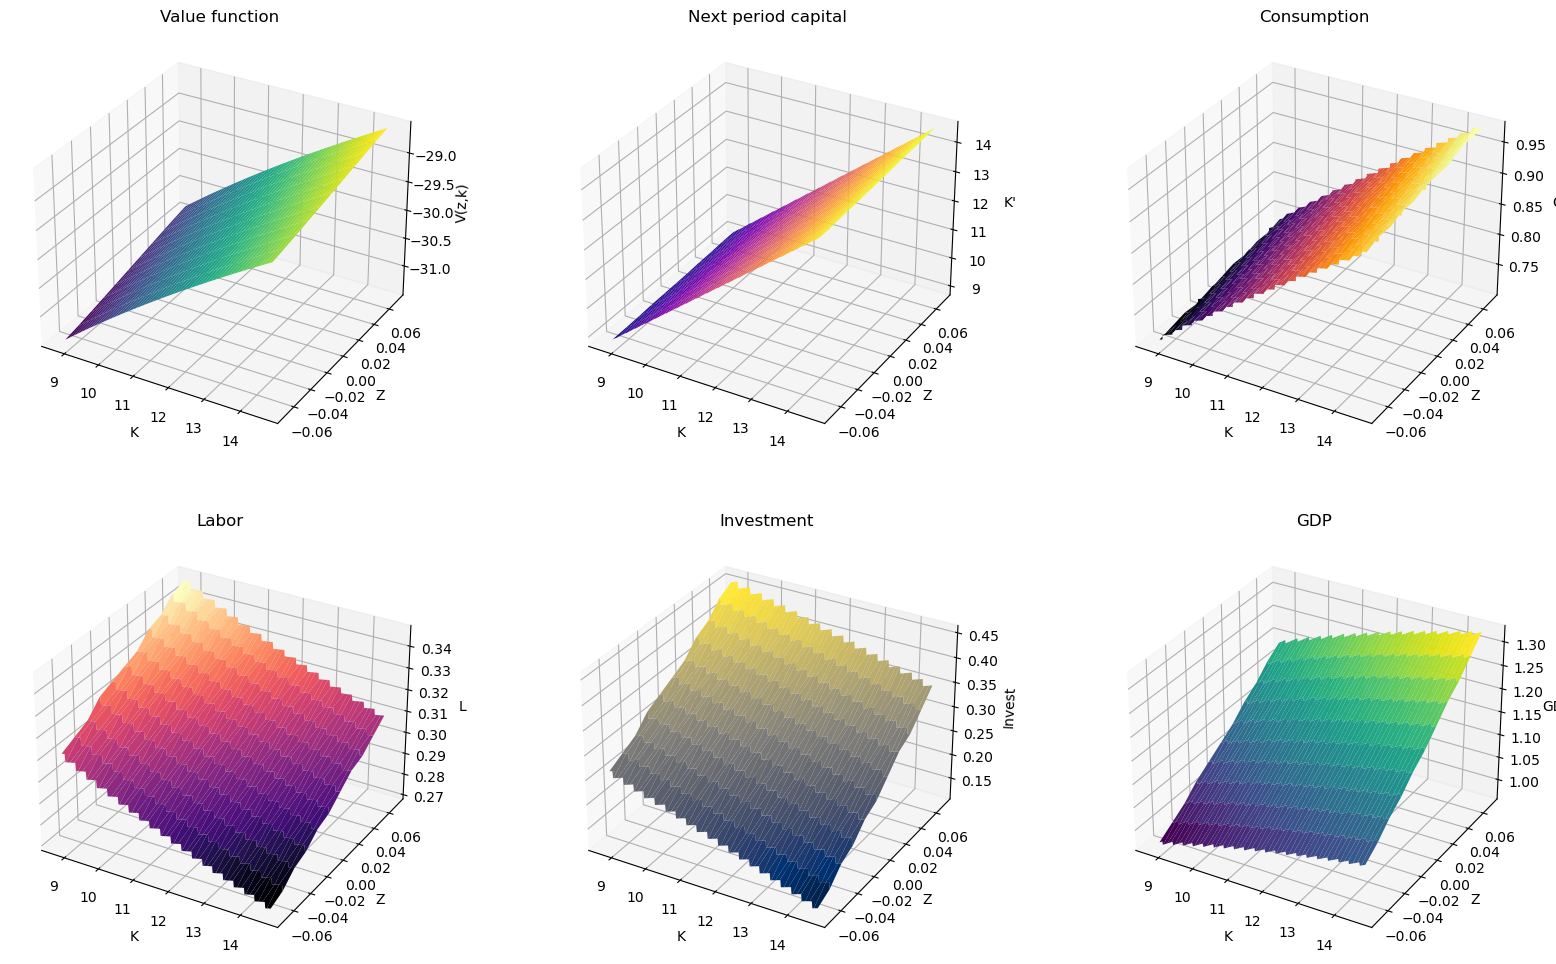

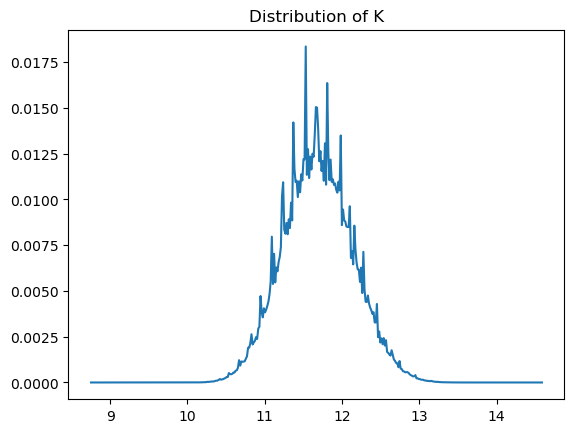

In [5]:
solution.graph()

In [6]:
solution.moments()

mean GDP                            = 1.139
mean Consumption                    = 0.847
mean Employment                     = 0.307
mean Investment                     = 0.292
mean Capital Stock                  = 11.686
% Std. dev. of GDP                  = 4.277
% Std. dev. of Consumption          = 2.62
% Std. dev. of Employment           = 1.871
% Std. dev. of Investment           = 11.569
% Std. dev. of Capital Stock        = 3.818
Corr. of Consumption with GDP       = 0.797
Corr. of Employment with GDP        = 0.81
Corr. of Investment with GDP        = 0.918
Autocorrelation of GDP              = 0.917
Autocorrelation of Consumption      = 0.984
Autocorrelation of Employment       = 0.835
Autocorrelation of Investment       = 0.857


# Solution with ϕ = 0.025

In [7]:
solution = final_Econ602(
                        β=.99,         # time discount rate
                        δ=0.025,        # depreciation rate
                        θ = 0.36,        # productivity parameter
                        μ = 0.34,
                        ϕ = 0.025,      # adjustment cost
                        ρ = 0.9,       # persistence parameter
                        η = 0.01,      # standard deviation
                        nk=400,          # number of points in k grid
                        nz=11,          #markov chain
                        tol=1e-9,       # error tolerance in iteration
                        maxit=10000)

In [8]:
solution.solve()
solution.kpr_policy()
solution.distr()

Running iteration 100 with dist of 0.11204010311497825
Running iteration 200 with dist of 0.028924488374887147
Running iteration 300 with dist of 0.007525328599673031
Running iteration 400 with dist of 0.0019597758053642167
Running iteration 500 with dist of 0.0004897329994051347
Running iteration 600 with dist of 0.00010822916102526392
Running iteration 700 with dist of 2.0052786666724387e-05
Running iteration 800 with dist of 3.2682434500941326e-06
Running iteration 900 with dist of 5.226222015153326e-07
Running iteration 1000 with dist of 8.346020408112054e-08
Running iteration 1100 with dist of 1.3271680643356376e-08
Running iteration 1200 with dist of 2.1084396450987697e-09


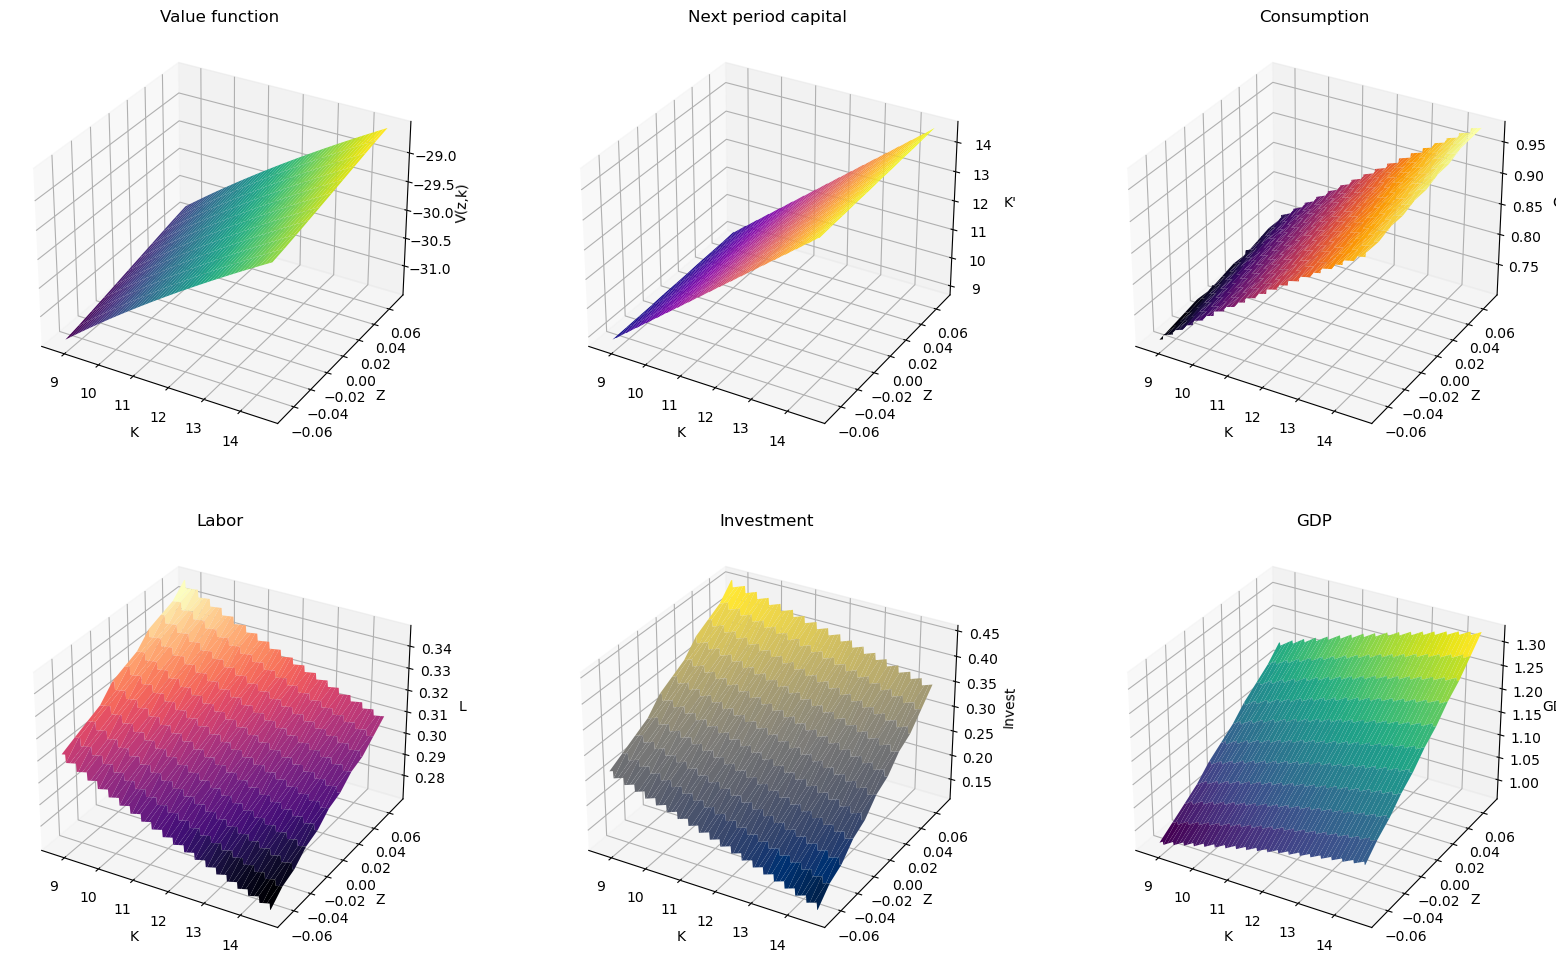

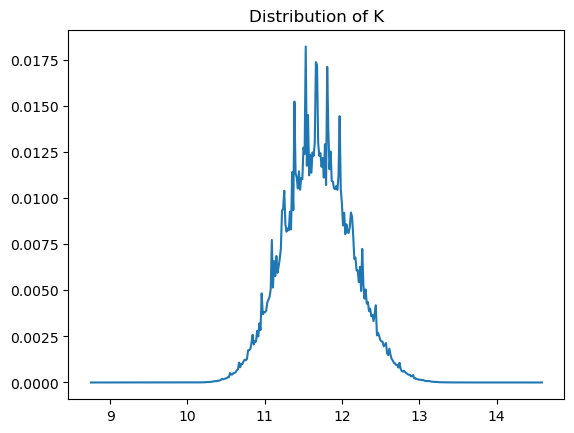

In [9]:
solution.graph()

In [10]:
solution.moments()

mean GDP                            = 1.139
mean Consumption                    = 0.847
mean Employment                     = 0.307
mean Investment                     = 0.292
mean Capital Stock                  = 11.685
% Std. dev. of GDP                  = 4.218
% Std. dev. of Consumption          = 2.603
% Std. dev. of Employment           = 1.799
% Std. dev. of Investment           = 11.224
% Std. dev. of Capital Stock        = 3.738
Corr. of Consumption with GDP       = 0.812
Corr. of Employment with GDP        = 0.81
Corr. of Investment with GDP        = 0.92
Autocorrelation of GDP              = 0.918
Autocorrelation of Consumption      = 0.983
Autocorrelation of Employment       = 0.834
Autocorrelation of Investment       = 0.857


# Solution with ϕ = 25

In [11]:
solution = final_Econ602(
                        β=.99,         # time discount rate
                        δ=0.025,        # depreciation rate
                        θ = 0.36,        # productivity parameter
                        μ = 0.34,
                        ϕ = 25,      # adjustment cost
                        ρ = 0.9,       # persistence parameter
                        η = 0.01,      # standard deviation
                        nk=400,          # number of points in k grid
                        nz=11,          #markov chain
                        tol=1e-9,       # error tolerance in iteration
                        maxit=10000)

In [12]:
solution.solve()
solution.kpr_policy()
solution.distr()

Running iteration 100 with dist of 0.11432446366297455
Running iteration 200 with dist of 0.02929795472585539
Running iteration 300 with dist of 0.007574180014021437
Running iteration 400 with dist of 0.0019693282011061797
Running iteration 500 with dist of 0.0005133675245190261
Running iteration 600 with dist of 0.00013397830765171648
Running iteration 700 with dist of 3.498509661170601e-05
Running iteration 800 with dist of 9.138096309868615e-06
Running iteration 900 with dist of 2.387242833634673e-06
Running iteration 1000 with dist of 6.237035776734956e-07
Running iteration 1100 with dist of 1.6296236537982622e-07
Running iteration 1200 with dist of 4.2581110193395943e-08
Running iteration 1300 with dist of 1.1126601862088137e-08
Running iteration 1400 with dist of 2.9075124530208996e-09


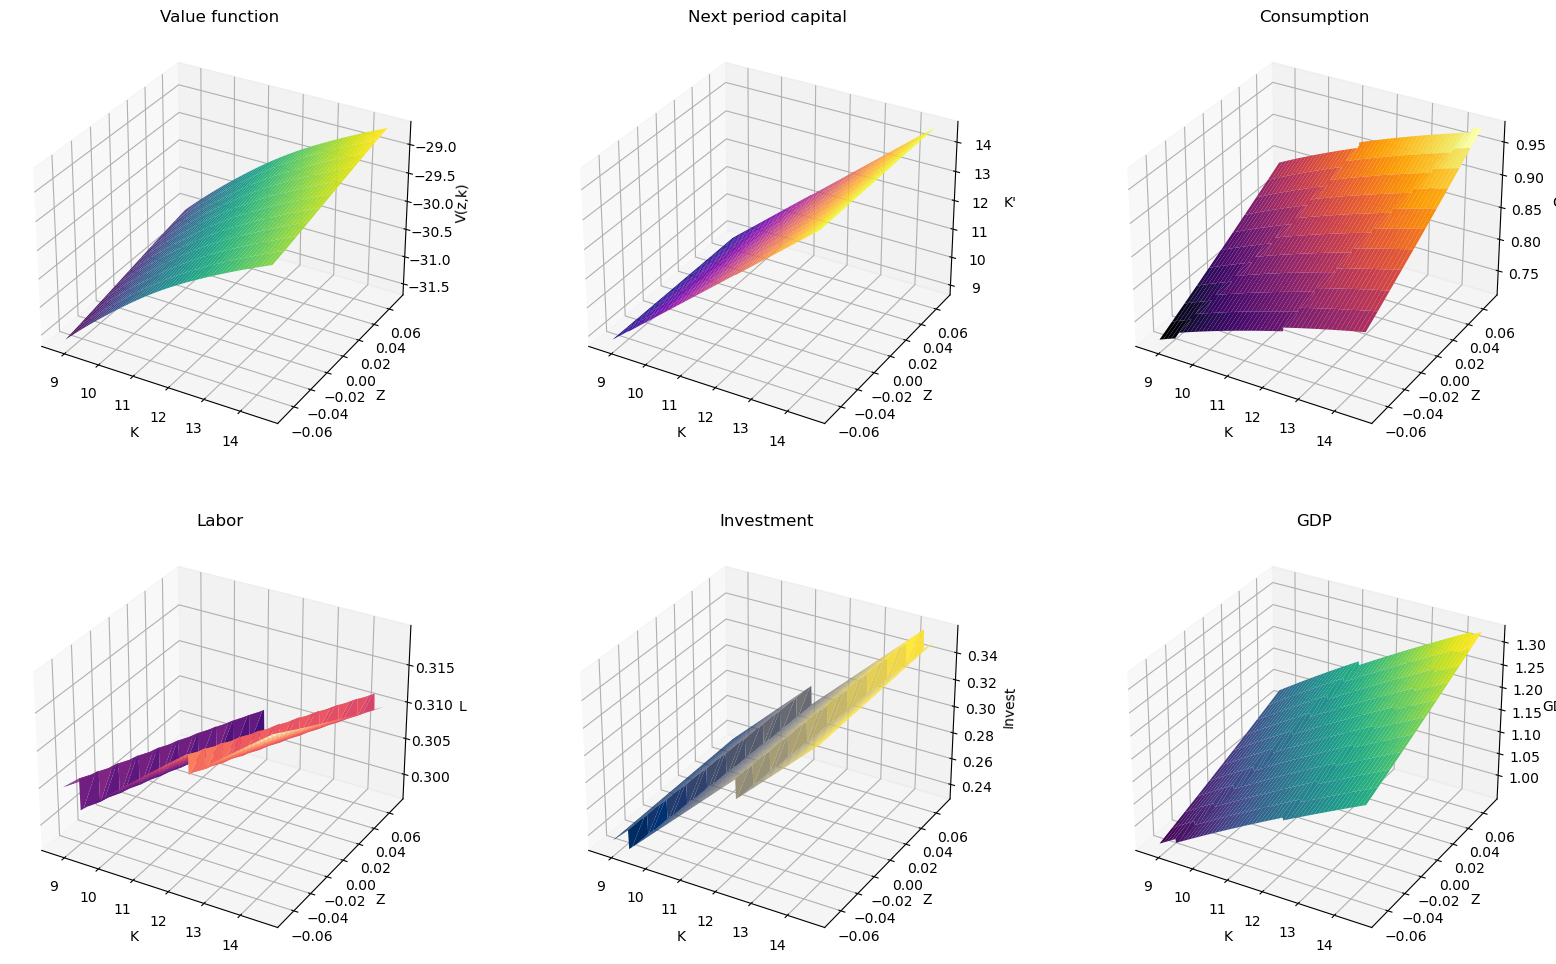

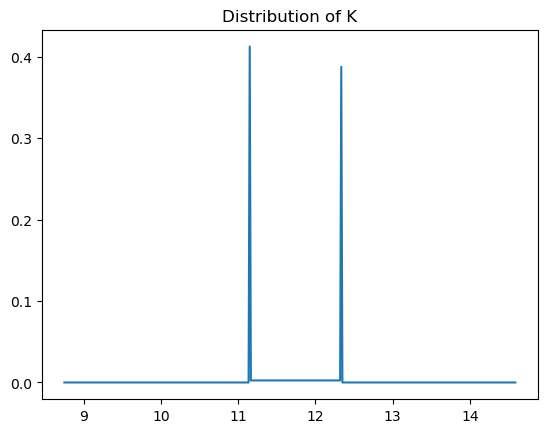

In [13]:
solution.graph()

In [14]:
solution.moments()

mean GDP                            = 1.14
mean Consumption                    = 0.847
mean Employment                     = 0.307
mean Investment                     = 0.293
mean Capital Stock                  = 11.728
% Std. dev. of GDP                  = 2.978
% Std. dev. of Consumption          = 3.093
% Std. dev. of Employment           = 0.806
% Std. dev. of Investment           = 4.695
% Std. dev. of Capital Stock        = 4.695
Corr. of Consumption with GDP       = 0.927
Corr. of Employment with GDP        = 0.095
Corr. of Investment with GDP        = 0.702
Autocorrelation of GDP              = 0.948
Autocorrelation of Consumption      = 0.913
Autocorrelation of Employment       = 0.959
Autocorrelation of Investment       = 1.0


In [16]:
solution.ks

11.669627053708636